# Synchronous Machine
Synchronous motors (SMs) are AC motors with constant speed.A SM dataset is obtained from a real experimental set. The task is to create the strong models to estimate the excitation current of SM.
Source:
Ramazan BAYINDIR (bayindir '@' gazi.edu.tr);Hamdi Tolga KAHRAMAN (holgakahraman '@' ktu.edu.tr);
Data Set Information:
Synchronous machine data were obtained in real time from the experimental operating environment.
Attribute Information:
Iy (Load Current) PF (Power factor) e (Power factor error) dIf (Changing of excitation current of synchronous machine) If (Excitation current of synchronous machine)
Relevant Papers:
Kahraman, H. T. (2014). Metaheuristic linear modeling technique for estimating the excitation current of a synchronous motor.Â Turkish Journal of Electrical Engineering & Computer Sciences,Â 22(6), 1637-1652.
Kahraman, H. T., Bayindir, R, & Sagiroglu, S. (2012). A new approach to predict the excitation current and parameter weightings of synchronous machines based on genetic algorithm-based k-NN estimator.Â Energy Conversion and Management,Â 64, 129-138.

In [4]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler,  LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score,recall_score,f1_score)
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import mean_squared_error

from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
import sklearn

%matplotlib inline
import os
import joblib as jb
import pickle
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.display.max_columns = None
pd.options.display.max_rows = 10

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.10 from "/Users/admin/anaconda3/bin/python"
  * The NumPy version is: "1.23.5"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: dlopen(/Users/admin/anaconda3/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so, 0x0002): Library not loaded: '@rpath/libopenblas.0.dylib'
  Referenced from: '/Users/admin/anaconda3/lib/python3.10/site-packages/numpy/core/_multiarray_umath.cpython-310-darwin.so'
  Reason: tried: '/Users/admin/anaconda3/lib/python3.10/site-packages/numpy/core/../../../../libopenblas.0.dylib' (no such file), '/Users/admin/anaconda3/lib/python3.10/site-packages/numpy/core/../../../../libopenblas.0.dylib' (no such file), '/Users/admin/anaconda3/bin/../lib/libopenblas.0.dylib' (no such file), '/Users/admin/anaconda3/bin/../lib/libopenblas.0.dylib' (no such file), '/usr/local/lib/libopenblas.0.dylib' (no such file), '/usr/lib/libopenblas.0.dylib' (no such file)


In [ ]:
# Load Data Set
dataset = pd.read_csv("synchronous_machine.csv", delimiter=";")

In [ ]:
print(dataset.dtypes)
print('Size of Data: ', dataset.shape)
dataset.head()

Iy     object
PF     object
e      object
dIf    object
If     object
dtype: object
Size of Data:  (557, 5)


,Iy,PF,e,dIf,If
0,3,"0,66","0,34","0,383","1,563"
1,3,"0,68","0,32","0,372","1,552"
2,3,"0,7","0,3","0,36","1,54"
3,3,"0,72","0,28","0,338","1,518"
4,3,"0,74","0,26","0,317","1,497"


In [ ]:
# Remove "commas" from dataset
def clean_and_change_to_numeric(data: pd.DataFrame):
    c = 0
    for col in data.columns:
        for j in range(len(data[col])):
            newstr = data.iloc[j,c].replace(",", ".")
            data.iloc[j,c] = newstr
        c += 1
    df = data.astype(np.float64)
    print(df.dtypes)
    return df

data = clean_and_change_to_numeric(dataset)


Iy     float64
PF     float64
e      float64
dIf    float64
If     float64
dtype: object


In [ ]:
# Check for missing values
data.isnull().sum()

Iy     0
PF     0
e      0
dIf    0
If     0
dtype: int64

The results shows that there are no missing values. We will check for outliers

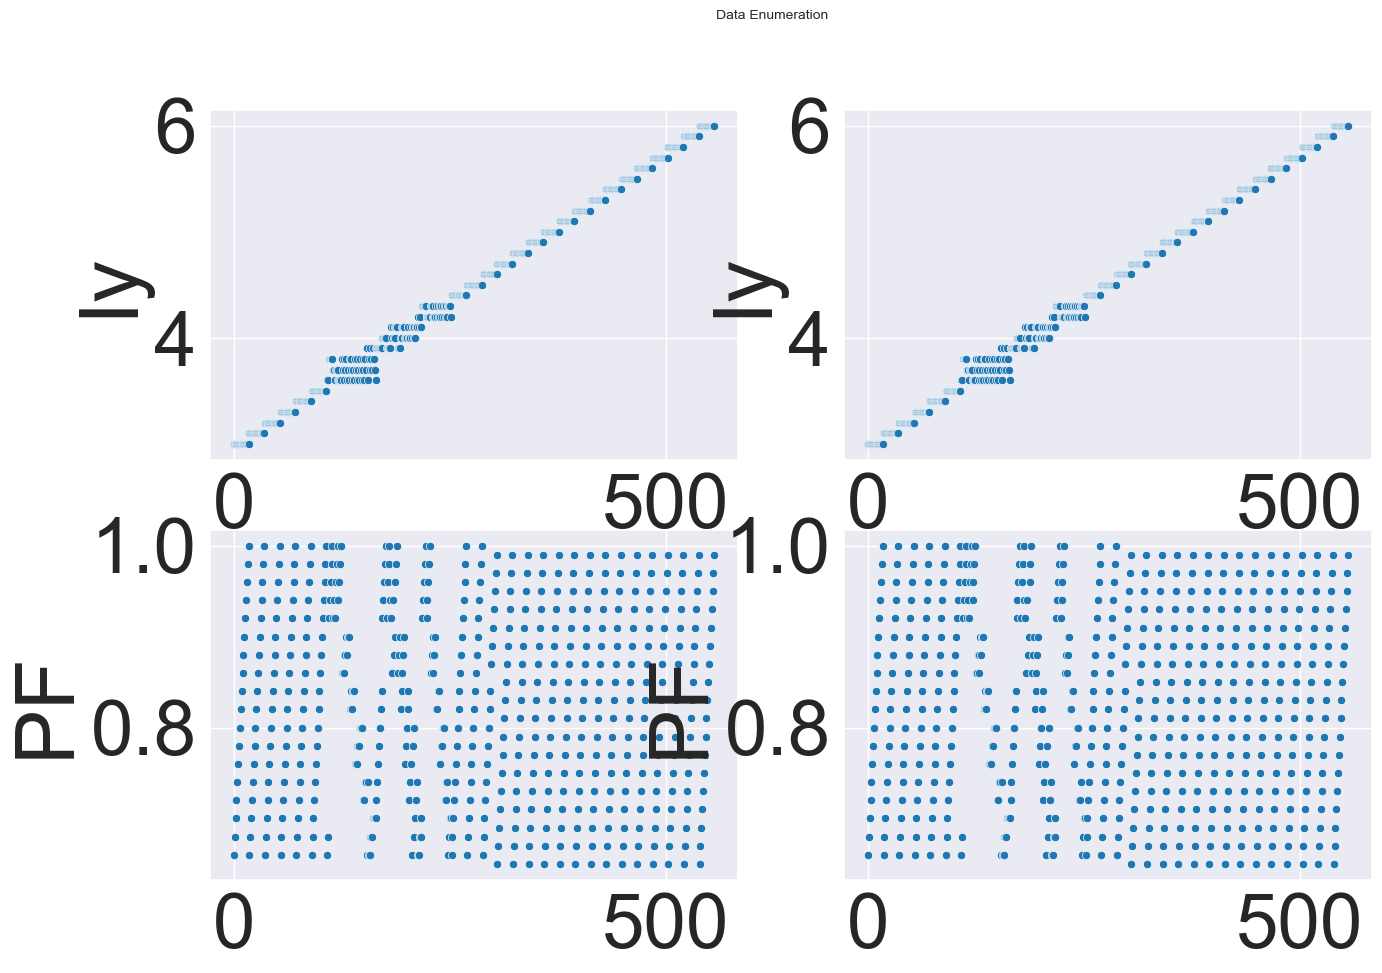

In [ ]:
def view_scatterplot(data: pd.DataFrame, nrows, ncols, titles):
    nn = 0
    n = data.shape
    cols = data.columns.tolist()
    fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
    fig1.suptitle(titles, fontsize=10)
    for i in range(0,nrows):
        for j in range(ncols): 
            sns.set_style("darkgrid")
            sns.set_context("notebook", font_scale = 5, rc={"grid.linewidth": 1})
            sns.scatterplot(x=data.index, y=data[cols[nn]], ax=ax1[i,j])
        nn += 1
        if i >= len(data):
            break
    
    plt.show
    
# Call method
view_scatterplot(pd.DataFrame(data.iloc[:,0:3], columns=data.columns), 2, 2, "Data Enumeration")


<function matplotlib.pyplot.show(close=None, block=None)>

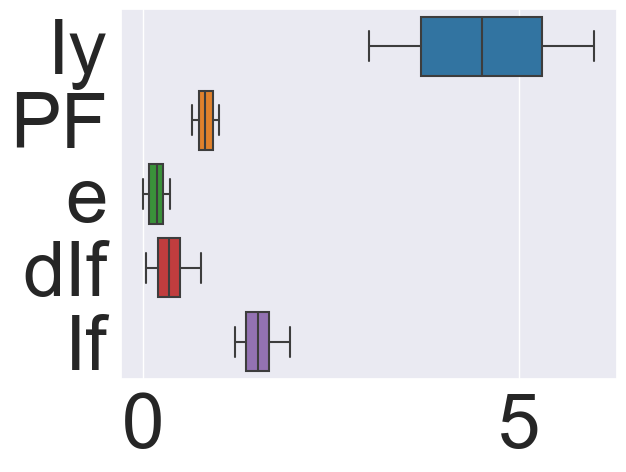

In [ ]:
# Detect outliers before treating missing values
sns.boxplot(data=data[['Iy', 'PF', 'e', 'dIf', 'If']], orient="h")
plt.show

From the scater and boxplot, we can see that there is no single outlier in the data set. 

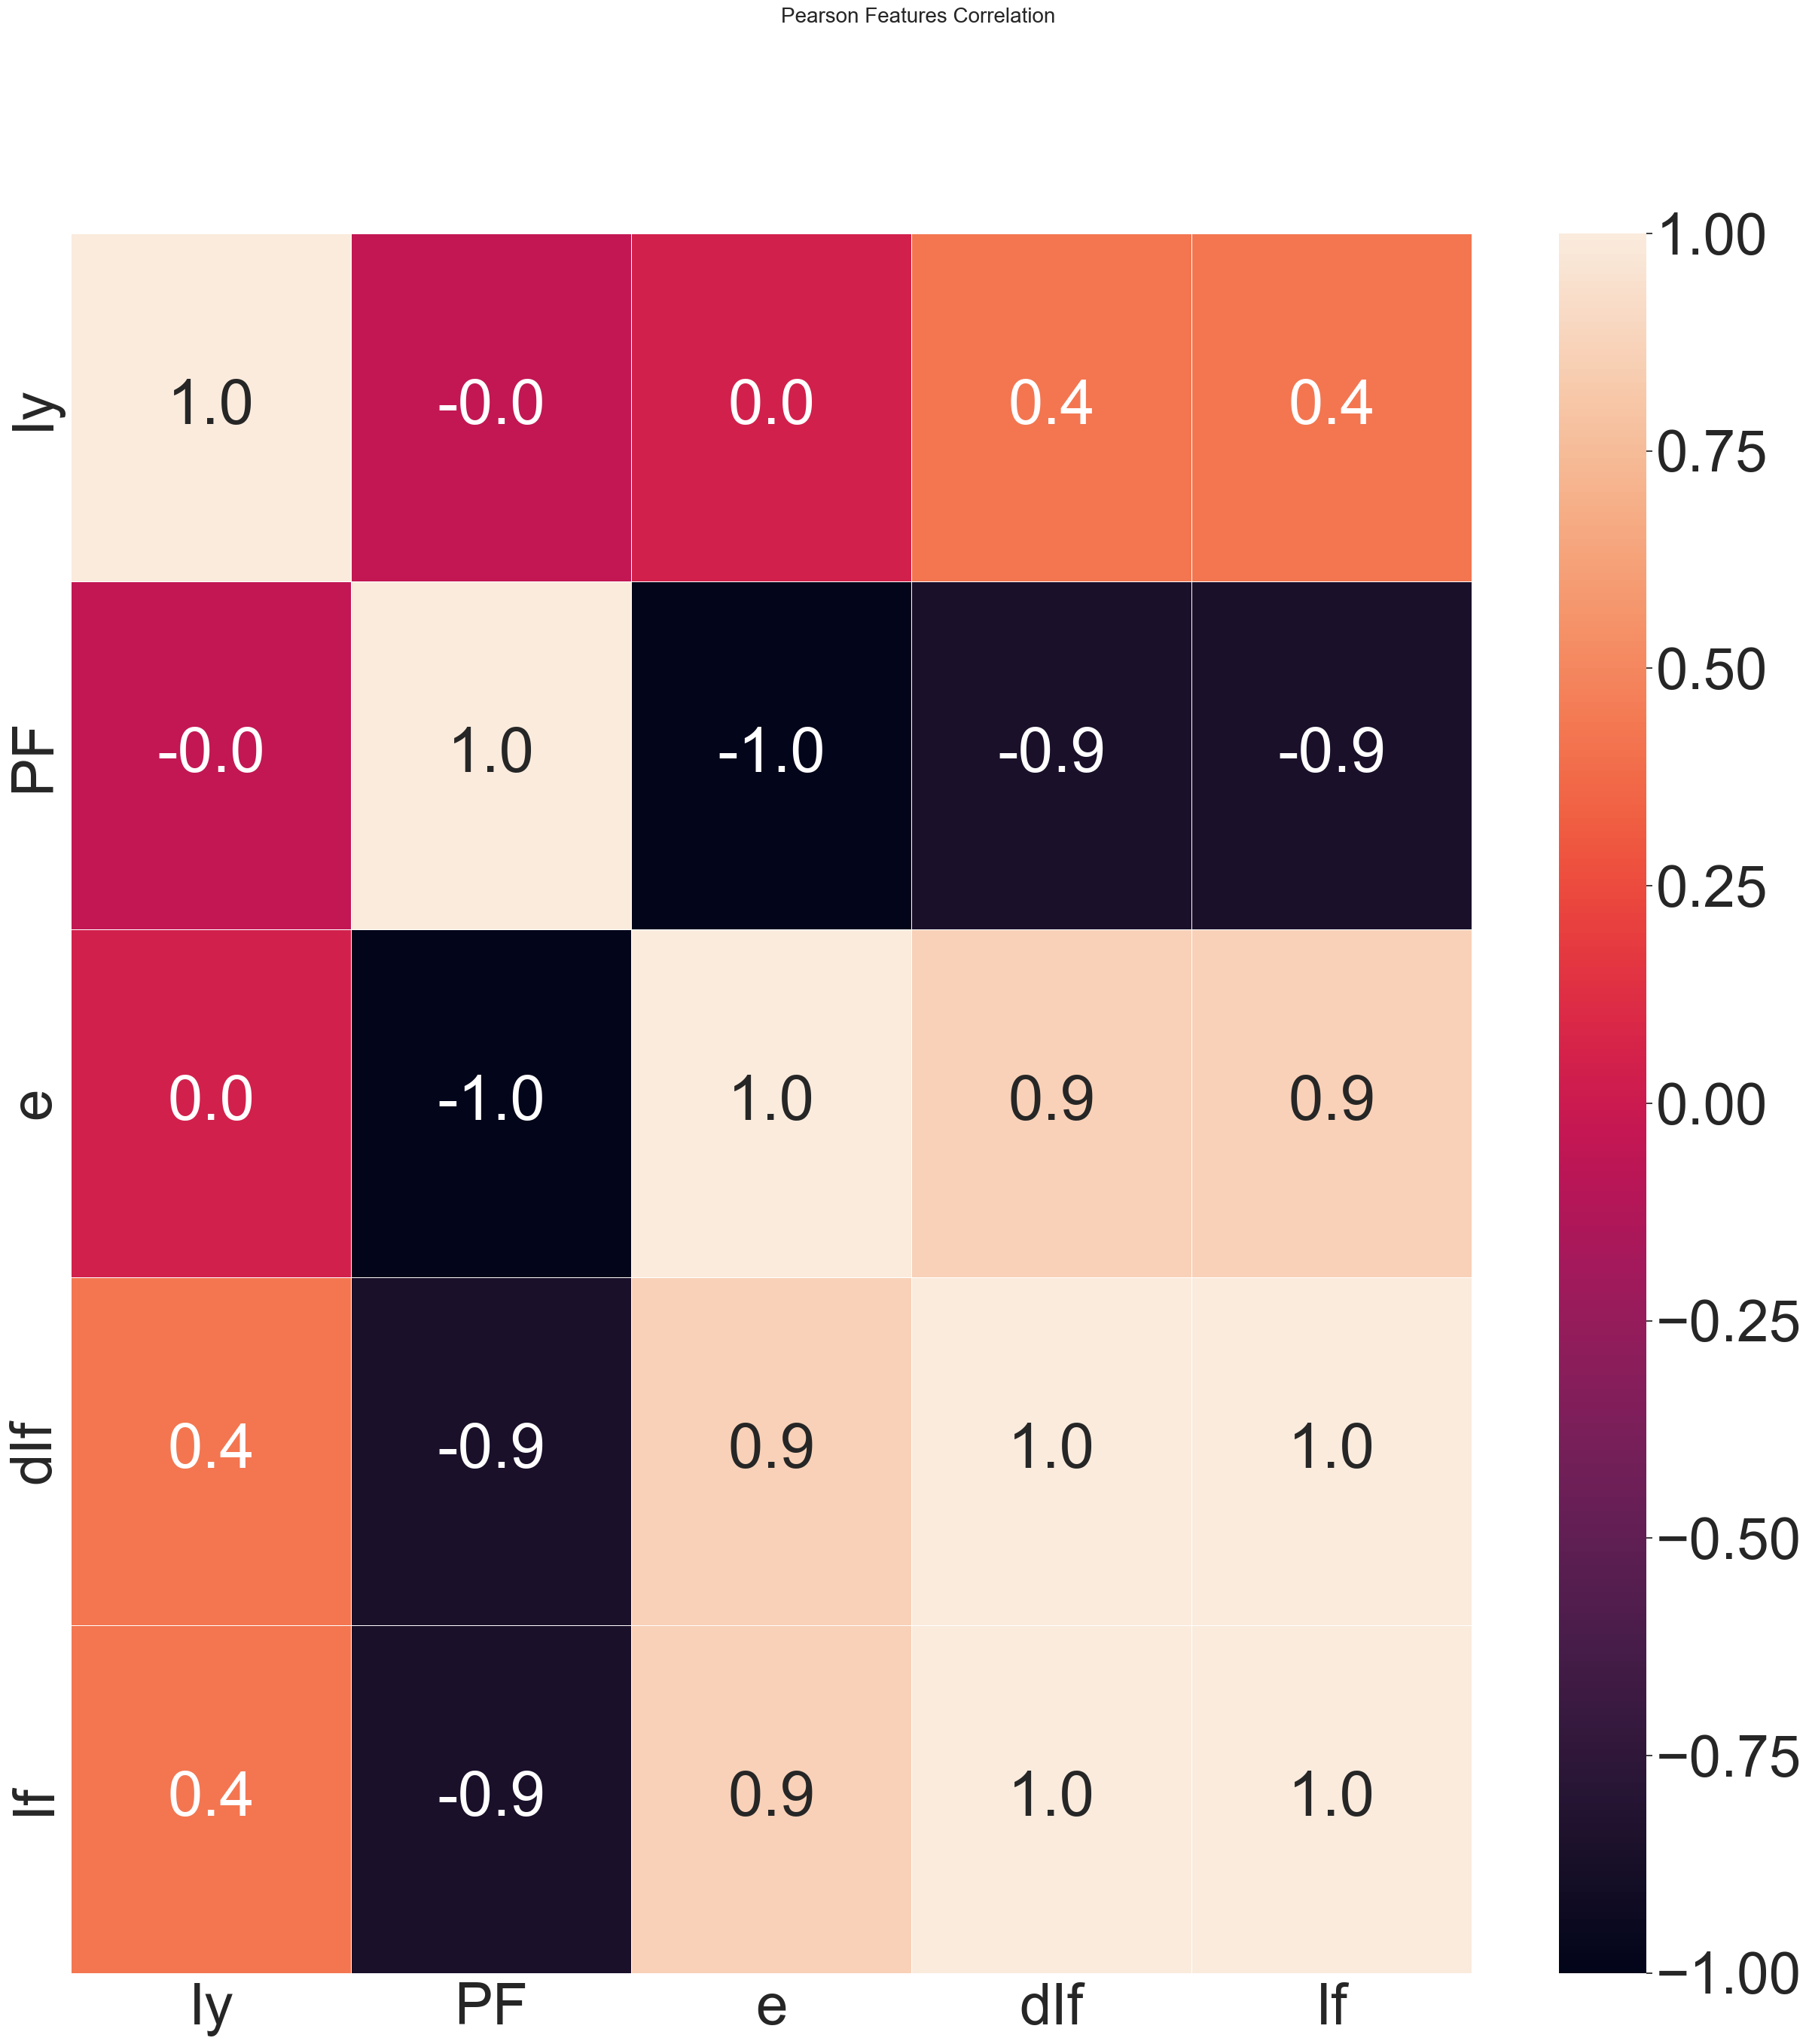

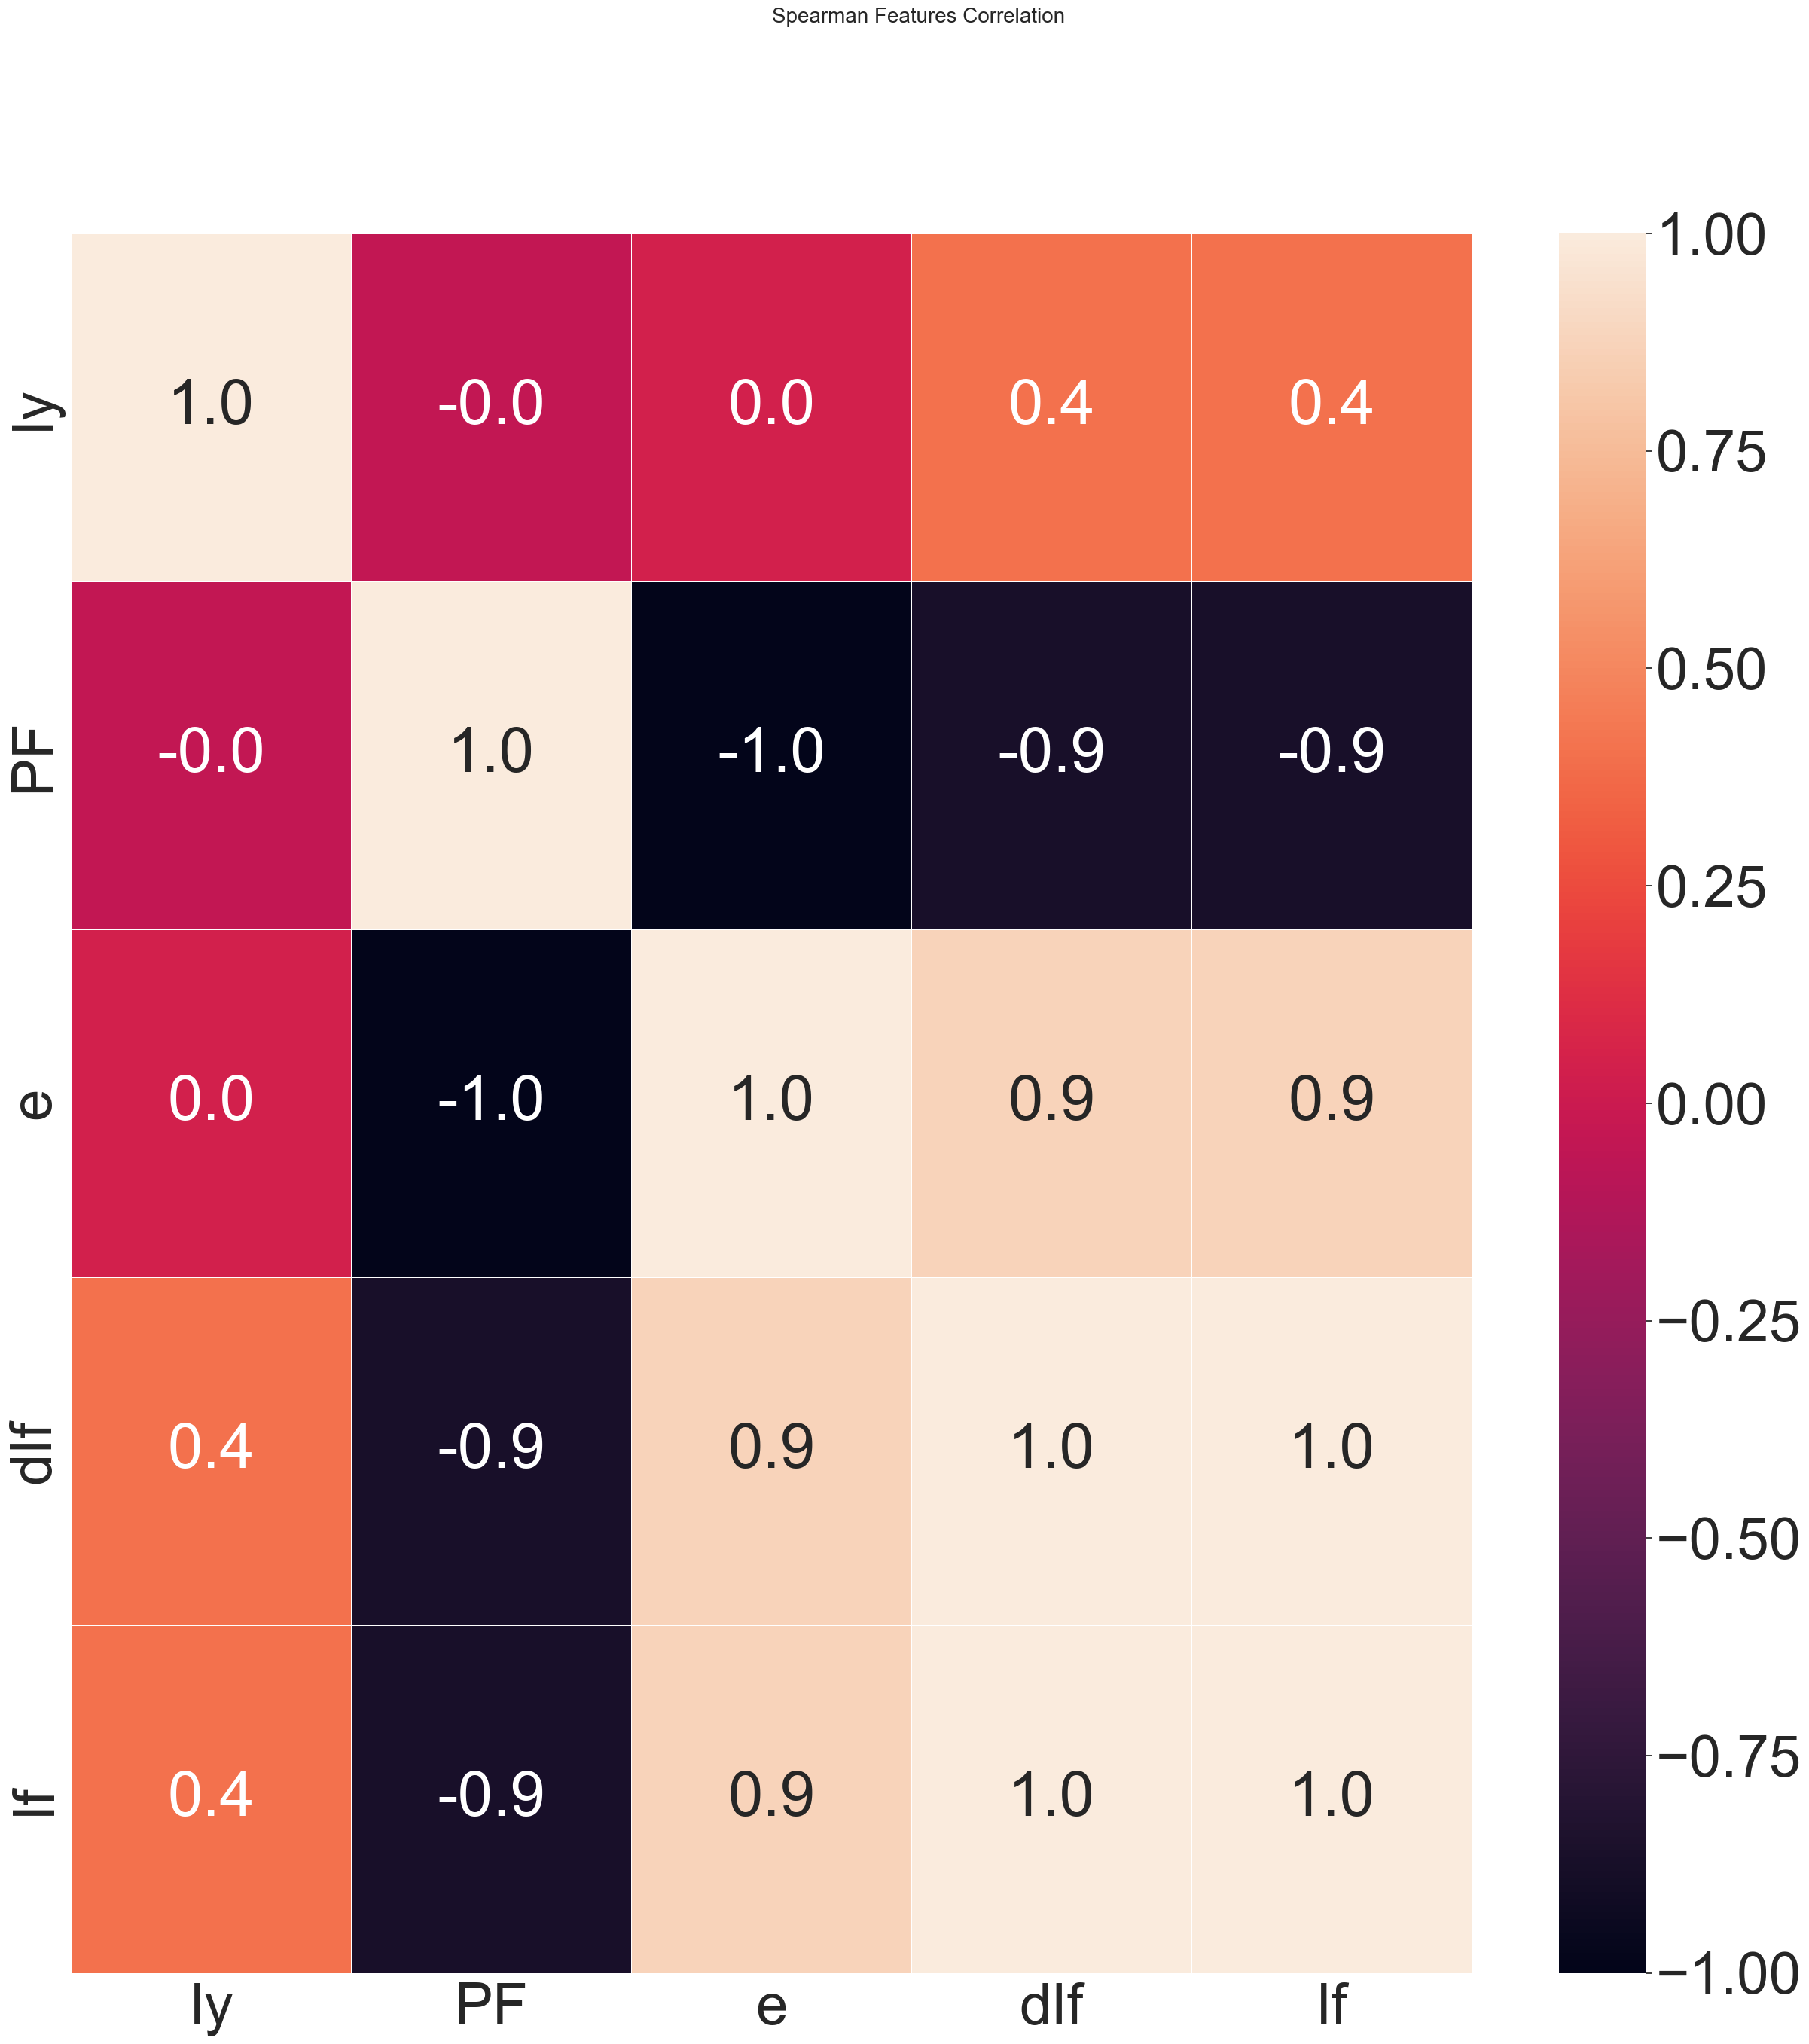

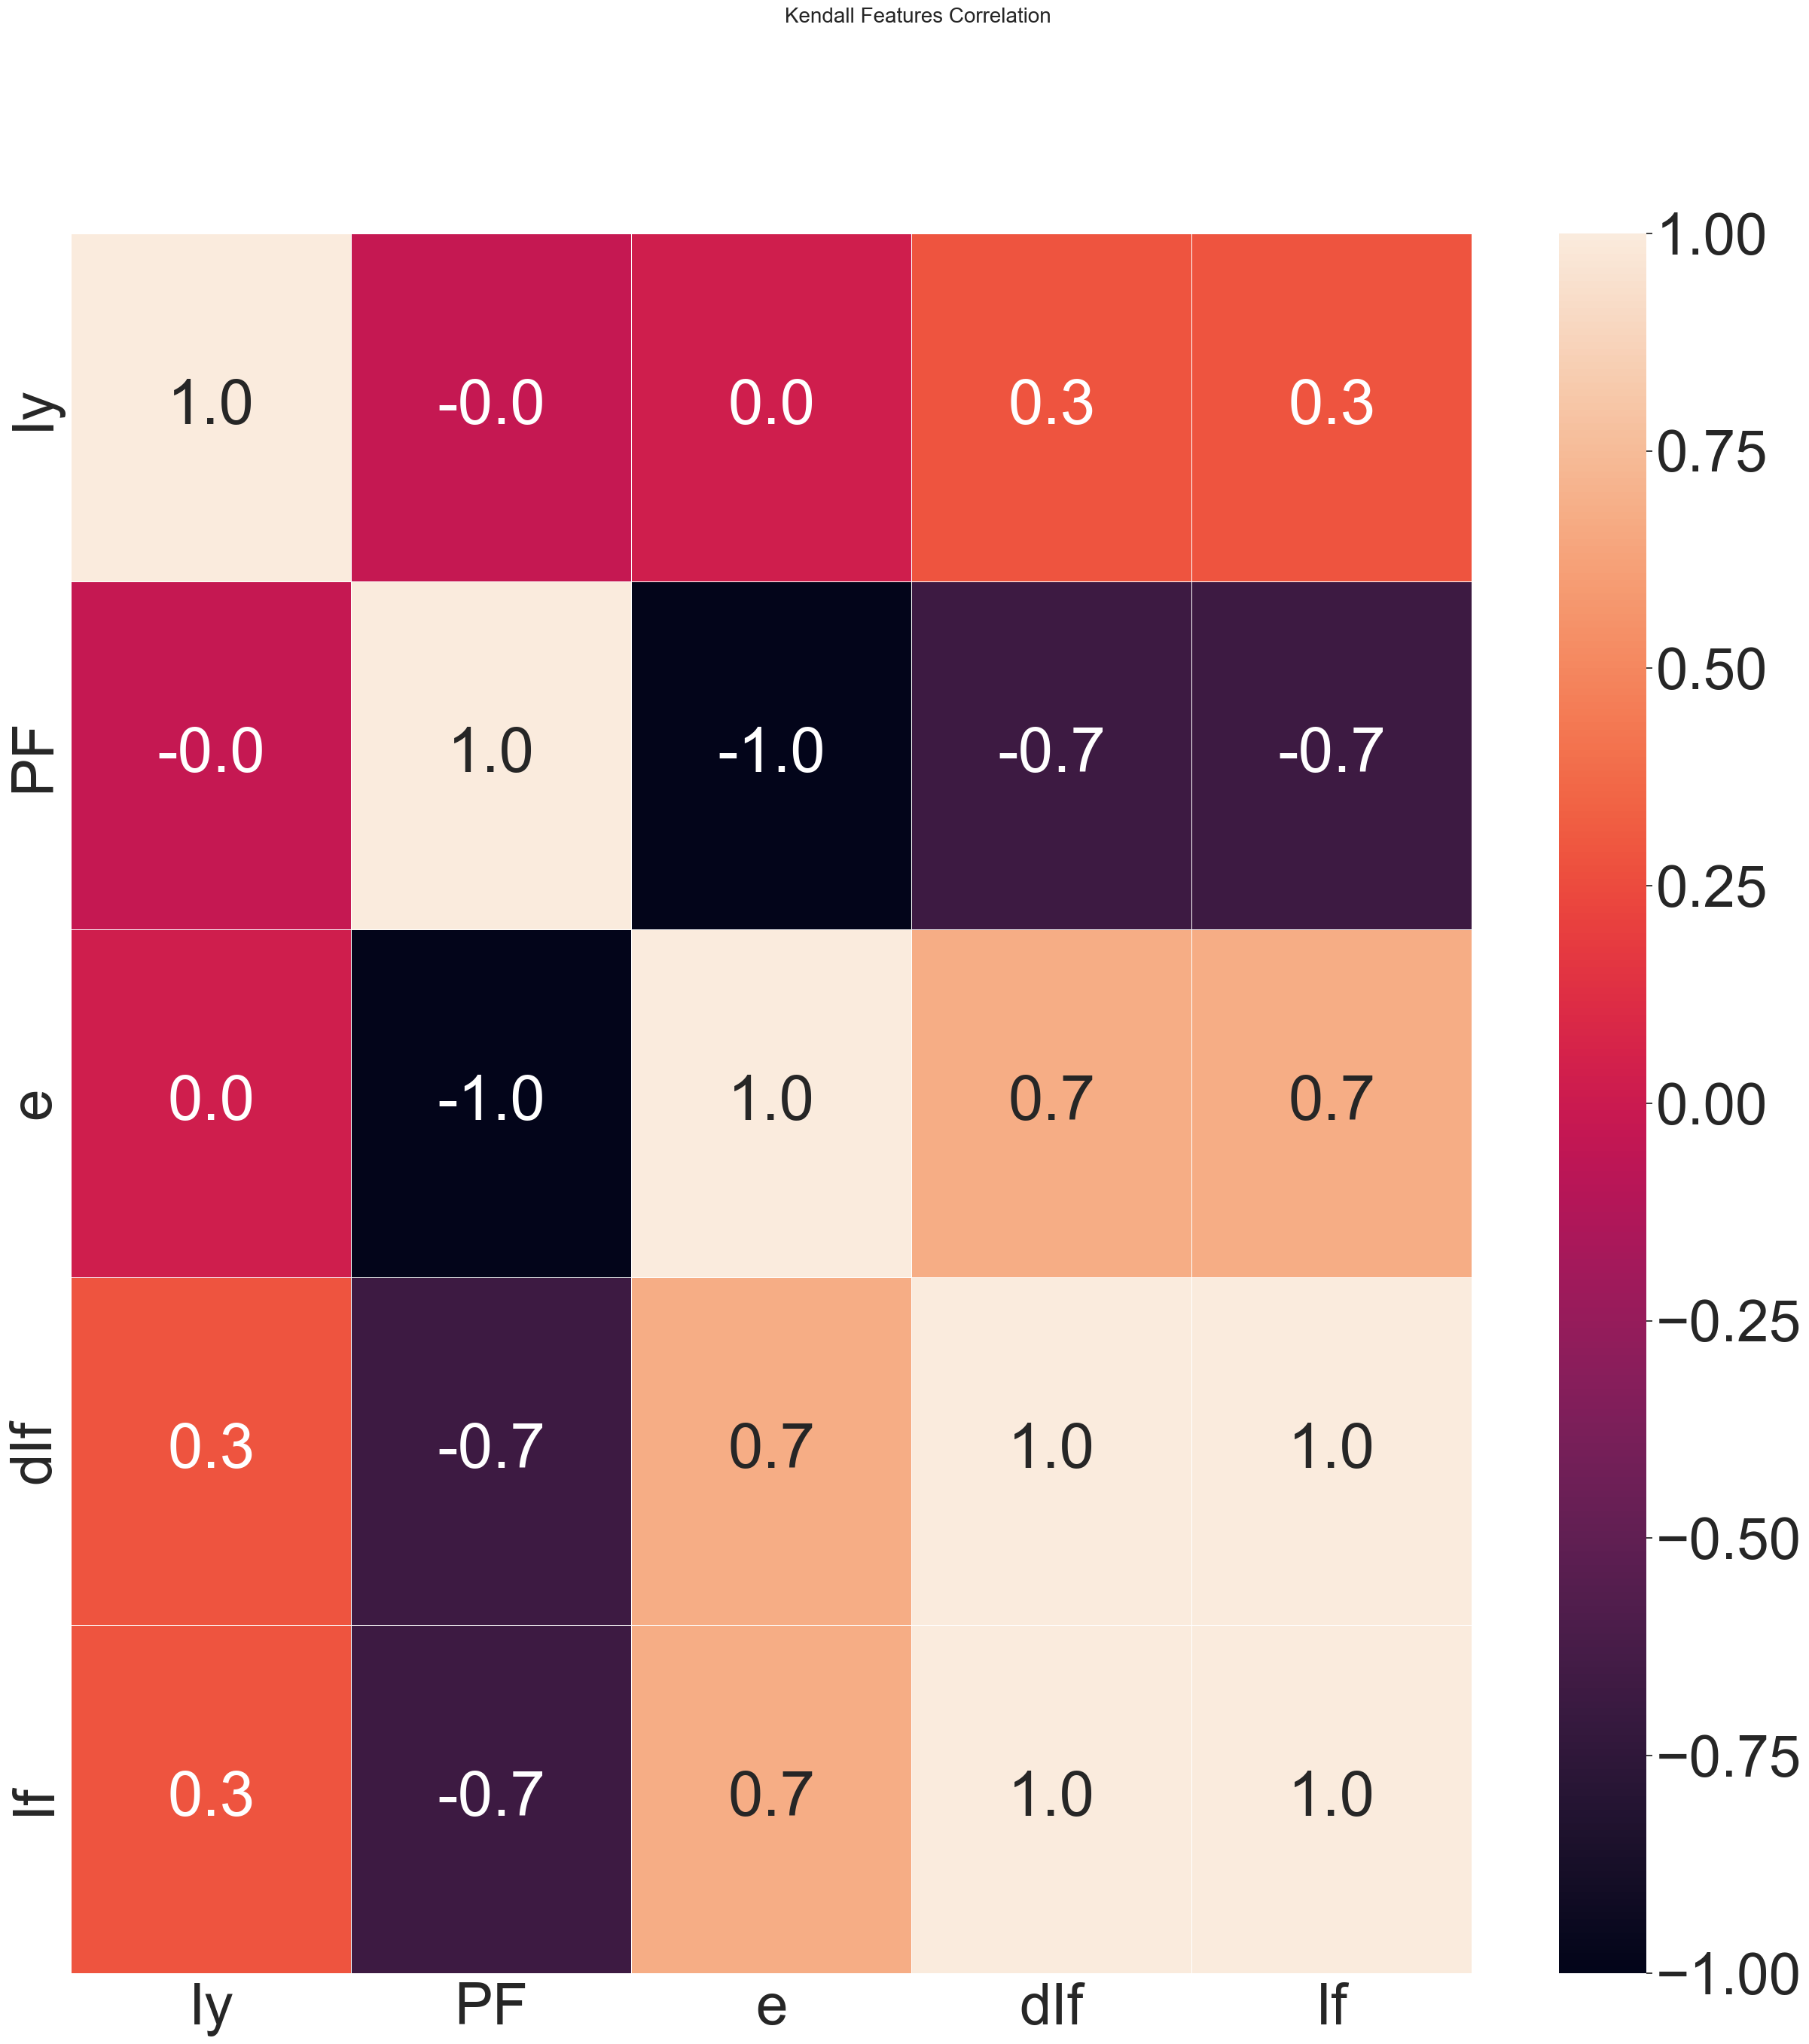

In [ ]:
def view_heatmap(data, titles):
    fig1, ax1 = plt.subplots(figsize=(30,30))
    fig1.suptitle(titles, fontsize=20)
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale = 5)
    sns.heatmap(data, cbar=True, linewidths=0.5, ax=ax1, annot=True, fmt=".1f", linewidth=.5)
    plt.show

# Call heatmap plot
data_corr1 = data.corr('pearson')
data_corr2 = data.corr('spearman')
data_corr3 = data.corr('kendall')
view_heatmap(data_corr1, "Pearson Features Correlation")
view_heatmap(data_corr2, "Spearman Features Correlation")
view_heatmap(data_corr3, "Kendall Features Correlation")

There seems to be a strong correlation between the data features. We will commence the modelling to see how far this will impact the models.

In [ ]:
# Dictionary of pipelines and classifier types for ease of reference
models_dict = {0: 'LinearRegression', 1: 'SVR', 2: 'LinearSVR', 
    3: 'KNeighborsRegressor', 4: 'DecisionTreeRegressor',
    5: 'DecisionTreeRegressor', 6: 'RandomForestRegressor',
    7: 'GradientBoostingRegressor'}

# Create models
lr = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1)
svr = svm.SVR()
svlr = svm.LinearSVR()
knnb = KNeighborsRegressor(n_neighbors=10)
dtc = DecisionTreeRegressor()
rfc = RandomForestRegressor()
extr = ExtraTreesRegressor()
gbc = GradientBoostingRegressor()

models = {0: lr, 1: svr, 2: svlr, 3: knnb, 4: dtc, 5: rfc, 6: extr, 7: gbc}

In [ ]:
# Cross validation with K-Fold
X_all = data[['Iy', 'PF', 'e', 'dIf']].values
y_all = data[['If']].values

print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''

kf = KFold(n_splits=5, random_state=42, shuffle=True)
cvscores = pd.DataFrame(data=None, columns=['kfold', 'loss', 'accuracy', 'model']) # Cross validation scores

for idx, gs in enumerate(models_dict):
    print('\nEstimator: %s' % models_dict[idx])
    print(idx)
    for i, (train_ix, test_ix) in enumerate(kf.split(X_all, y_all)):
    
        history = models[idx].fit(X_all[train_ix], y_all[train_ix])
        # evaluate the model
        scores = models[idx].score(X_all[train_ix], y_all[train_ix])
        # Predict on test data with best params
        y_pred = models[idx].predict(X_all[test_ix])
        loss = mean_squared_error(y_all[test_ix], y_pred)
      
        print('> folds=%d, loss=%.3f, accuracy=%.3f, model=%s' % (i, scores, loss, models[idx]))
        cvscores.loc[len(cvscores)] = [i, loss, scores, models[idx]]


        # Track best (highest test accuracy) model
        if scores > best_acc:
            best_acc = scores
            best_gs = models[idx] 
            best_clf = idx
            print('\nClassifier with best test set accuracy: %s' % models_dict[best_clf])

    # Save best grid search pipeline to file
    dump_file = 'best_gs_model_0.1.0.pkl'
    pickle.dump(best_gs, dump_file, compress=1)
    print('\nSaved %s grid search pipeline to file: %s' % (models_dict[best_clf], dump_file))


    

Performing model optimizations...

Estimator: LinearRegression
0
> folds=0, loss=1.000, accuracy=0.000, model=LinearRegression(n_jobs=-1)

Classifier with best test set accuracy: LinearRegression
> folds=1, loss=1.000, accuracy=0.000, model=LinearRegression(n_jobs=-1)
> folds=2, loss=1.000, accuracy=0.000, model=LinearRegression(n_jobs=-1)
> folds=3, loss=1.000, accuracy=0.000, model=LinearRegression(n_jobs=-1)
> folds=4, loss=1.000, accuracy=0.000, model=LinearRegression(n_jobs=-1)

Saved LinearRegression grid search pipeline to file: best_gs_model_0.1.0.pkl

Estimator: SVR
1
> folds=0, loss=0.909, accuracy=0.003, model=SVR()
> folds=1, loss=0.916, accuracy=0.003, model=SVR()
> folds=2, loss=0.907, accuracy=0.003, model=SVR()
> folds=3, loss=0.909, accuracy=0.003, model=SVR()
> folds=4, loss=0.912, accuracy=0.003, model=SVR()

Saved LinearRegression grid search pipeline to file: best_gs_model_0.1.0.pkl

Estimator: LinearSVR
2
> folds=0, loss=1.000, accuracy=0.000, model=LinearSVR()
> 

In [ ]:
cvscores.head()

,kfold,loss,accuracy,model
0,0,1.980957e-32,1.0,LinearRegression(n_jobs=-1)
1,1,2.861382e-32,1.0,LinearRegression(n_jobs=-1)
2,2,4.797127e-32,1.0,LinearRegression(n_jobs=-1)
3,3,2.531817e-32,1.0,LinearRegression(n_jobs=-1)
4,4,1.332535e-32,1.0,LinearRegression(n_jobs=-1)


In [ ]:
np.__version__

'1.23.5'